In [27]:
# https://www.kaggle.com/c/facial-keypoints-detection/data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import tensorflow
import os 
import sys

cwd = os.getcwd()

dataDir = "E:\\TK_PracticeDatabases\\facial-keypoints-detection"
os.chdir(dataDir)
testData = pd.read_csv("test.csv")
trainingData = pd.read_csv("training.csv")
idLookupData = pd.read_csv("IdLookupTable.csv")
sampleSubData = pd.read_csv("SampleSubmission.csv")

imageSize = (96,96) # defined in the Data header

os.chdir(cwd)

print(trainingData)

      left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0             66.033564          39.002274           30.227008   
1             64.332936          34.970077           29.949277   
2             65.057053          34.909642           30.903789   
3             65.225739          37.261774           32.023096   
4             66.725301          39.621261           32.244810   
5             69.680748          39.968748           29.183551   
6             64.131866          34.290040           29.578953   
7             67.468893          39.413452           29.355961   
8             65.802880          34.755200           27.475840   
9             64.121231          36.740308           29.468923   
10            65.230189          34.342642           28.802717   
11            66.737600          39.886400           30.270400   
12            66.574737          37.308000           30.445263   
13            65.270588          34.940235           33.022745   
14        

In [98]:
class TrainImage:
    def __init__(self, trainData, index):
        
        self.leftEyeCenterFloat = (trainData["left_eye_center_y"][index],
                                   trainData["left_eye_center_x"][index])
        self.leftEyeCenterInt = (int(trainData["left_eye_center_y"][index]), 
                                 int(trainData["left_eye_center_x"][index]))
        
        self.leftEyeCantusFloat = (trainData["left_eye_inner_corner_y"][index], 
                                   trainData["left_eye_inner_corner_x"][index])
        self.leftEyeCantusInt = (int(trainData["left_eye_inner_corner_y"][index]), 
                                 int(trainData["left_eye_inner_corner_x"][index]))
        
        self.leftEyeOuterFloat = (trainData["left_eye_outer_corner_y"][index], 
                                  trainData["left_eye_outer_corner_x"][index])
        self.leftEyeOuterInt = (int(trainData["left_eye_outer_corner_y"][index]), 
                                 int(trainData["left_eye_outer_corner_x"][index]))
        
        self.rightEyeCenterFloat = (trainData["right_eye_center_y"][index], 
                                    trainData["right_eye_center_x"][index])
        self.rightEyeCenterInt = (int(trainData["right_eye_center_y"][index]), 
                                 int(trainData["right_eye_center_x"][index]))
        
        self.rightEyeCantusFloat = (trainData["right_eye_inner_corner_y"][index], 
                                   trainData["right_eye_inner_corner_x"][index])
        self.rightEyeCantusInt = (int(trainData["right_eye_inner_corner_y"][index]), 
                                 int(trainData["right_eye_inner_corner_x"][index]))
        
        self.rightEyeOuterFloat = (trainData["right_eye_outer_corner_y"][index], 
                                  trainData["right_eye_outer_corner_x"][index])
        self.rightEyeOuterInt = (int(trainData["right_eye_outer_corner_y"][index]),
                                 int(trainData["right_eye_outer_corner_x"][index])) 
        
        self.leftEyebrowInnerFloat= (trainData["left_eyebrow_inner_end_y"][index], 
                                     trainData["left_eyebrow_inner_end_x"][index])
        self.leftEyebrowInnerInt = (int(trainData["left_eyebrow_inner_end_y"][index]), 
                                 int(trainData["left_eyebrow_inner_end_x"][index]))
        
        self.leftEyebrowOuterFloat= (trainData["left_eyebrow_outer_end_y"][index], 
                                     trainData["left_eyebrow_outer_end_x"][index])
        self.leftEyebrowOuterInt = (int(trainData["left_eyebrow_outer_end_y"][index]), 
                                    int(trainData["left_eyebrow_outer_end_x"][index]))

        self.rightEyebrowInnerFloat= (trainData["right_eyebrow_inner_end_y"][index], 
                                      trainData["right_eyebrow_inner_end_x"][index])
        self.rightEyebrowInnerInt = (int(trainData["right_eyebrow_inner_end_y"][index]), 
                                     int(trainData["right_eyebrow_inner_end_x"][index]))
        
        self.rightEyebrowOuterFloat= (trainData["right_eyebrow_outer_end_y"][index], 
                                     trainData["right_eyebrow_outer_end_x"][index])
        self.rightEyebrowOuterInt = (int(trainData["right_eyebrow_outer_end_y"][index]), 
                                     int(trainData["right_eyebrow_outer_end_x"][index]))
        
        self.noiseTipFloat = (trainData["nose_tip_y"], trainData["nose_tip_x"][index])
        self.noiseTipInt = (int(trainData["nose_tip_y"][index]), 
                            int(trainData["nose_tip_x"][index]))
        
        self.mouthLeftFloat = (trainData["mouth_left_corner_y"][index], 
                               trainData["mouth_left_corner_x"][index])
        self.mouthLeftInt = (int(trainData["mouth_left_corner_y"][index]), 
                             int(trainData["mouth_left_corner_x"][index]))
        
        self.mouthRightFloat = (trainData["mouth_right_corner_y"][index], 
                                trainData["mouth_right_corner_x"][index])
        self.mouthRightInt = (int(trainData["mouth_right_corner_y"][index]), 
                             int(trainData["mouth_right_corner_x"][index]))
        
        self.mouthTopFloat = (trainData["mouth_center_top_lip_y"][index], 
                              trainData["mouth_center_top_lip_x"][index])
        self.mouthTopInt = (int(trainData["mouth_center_top_lip_y"][index]), 
                            int(trainData["mouth_center_top_lip_x"][index]))
                
        self.mouthBottomFloat = (trainData["mouth_center_bottom_lip_y"][index], 
                                 trainData["mouth_center_bottom_lip_x"][index])
        self.mouthBottomInt = (int(trainData["mouth_center_bottom_lip_y"][index]), 
                               int(trainData["mouth_center_bottom_lip_x"][index]))
        
        self.image = self.formatImage(trainData["Image"][index])
        self.labeledImage = self.LabeledImage()
        
    def formatImage(self, ImageStrArray):
        imageParse = ImageStrArray.split(' ')
        imageInt = np.array(imageParse, dtype=int)
        image = np.reshape(imageInt,imageSize)
        return image
    
    def ShowImage(self, cmap = 'Spectral'):
        plt.figure()
        plt.imshow(self.image)
        plt.show()
        
        plt.figure()
        plt.imshow(self.labeledImage, cmap=cmap)
        plt.show()
    
    def LabeledImage(self):
        temp_image = np.array(self.image) #MUST REFORMAT SO THAT IT DOESNT USE SAME DATA
        temp_image[self.leftEyebrowInnerInt] = 0 
        temp_image[self.leftEyebrowOuterInt] = 0
        
        temp_image[self.leftEyeCantusInt] = 0 
        temp_image[self.leftEyeCenterInt] = 0
        temp_image[self.leftEyeOuterInt] = 0 
        
        temp_image[self.mouthBottomInt] = 0
        temp_image[self.mouthLeftInt] = 0
        temp_image[self.mouthRightInt] = 0
        temp_image[self.mouthTopInt] = 0
        
        temp_image[self.rightEyebrowInnerInt] = 0
        temp_image[self.rightEyebrowOuterInt] = 0
        
        temp_image[self.rightEyeCantusInt] = 0 
        temp_image[self.rightEyeCenterInt] = 0
        temp_image[self.rightEyeOuterInt] = 0
        
        temp_image[self.noiseTipInt] = 0
        
        return temp_image

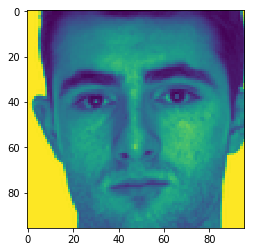

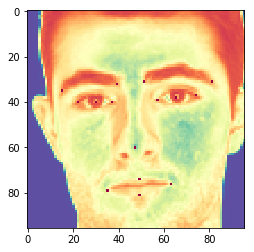

In [99]:
patient = TrainImage(trainingData, 1291)
patient.ShowImage()

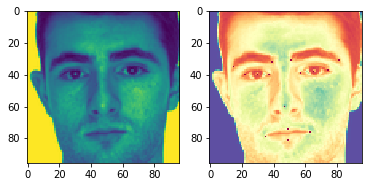

In [101]:
plt.subplot(121)
plt.imshow(patient.image)
plt.subplot(122)
plt.imshow(patient.labeledImage, cmap = 'Spectral')
plt.show()


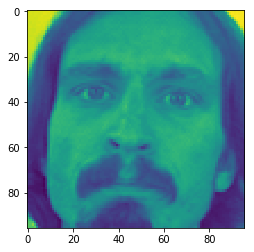

In [28]:
os.mkdir("Images")
os.chdir("Images")
for i in range(len(trainingData)):
    

In [83]:
len(trainingData)

7049

In [61]:
print(patient.leftEyebrowInnerFloat)
print(patient.leftEyebrowInnerInt)

(56.9532631579, 29.0336481203)
(56, 29)


In [68]:
# save here just in case something goes wrong
class TrainImage:
    def __init__(left_eye_center_x, left_eye_center_y,
                 right_eye_center_x, right_eye_center_y, 
                 left_eye_inner_corner_x, left_eye_inner_corner_y,
                 left_eye_outer_corner_x, left_eye_outer_corner_y,
                 right_eye_inner_corner_x, right_eye_inner_corner_y,
                 right_eye_outer_corner_x, right_eye_outer_corner_y,
                 left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, 
                 left_eyebrow_outer_end_x, left_eyebrow_outer_end_y,
                 right_eyebrow_inner_end_x, right_eyebrow_inner_end_y,
                 right_eyebrow_outer_end_x, right_eyebrow_outer_end_y,
                 nose_tip_x, nose_tip_y, 
                 mouth_left_corner_x, mouth_left_corner_y, 
                 mouth_right_corner_x, mouth_right_corner_y,
                 mouth_center_top_lip_x, mouth_center_top_lip_y, 
                 mouth_center_bottom_lip_x, mouth_center_bottom_lip_y,
                 ImageStrArray):
        
        self.leftEyeCenterFloat = (left_eye_center_x, left_eye_center_y)
        self.leftEyeCenterInt = (int(left_eye_center_x), 
                                 int(left_eye_center_y))
        
        self.leftEyeCantusFloat = (left_eye_inner_corner_x, 
                                   left_eye_inner_corner_y)
        self.leftEyeCantusInt = (int(left_eye_inner_corner_x), 
                                 int(left_eye_inner_corner_y))
        
        self.leftEyeOuterFloat = (left_eye_outer_corner_x, 
                                  left_eye_outer_corner_y)
        self.leftEyeOuterInt = (int(left_eye_outer_corner_x), 
                                 int(left_eye_outer_corner_y))
        
        self.rightEyeCenterFloat = (right_eye_center_x, right_eye_center_y)
        self.rightEyeCenterInt = (int(right_eye_center_x), 
                                 int(right_eye_center_y))
        
        self.rightEyeCantusFloat = (right_eye_inner_corner_x, 
                                   rightt_eye_inner_corner_y)
        self.rightEyeCantusInt = (int(right_eye_inner_corner_x), 
                                 int(right_eye_inner_corner_y))
        
        self.rightEyeOuterFloat = (right_eye_outer_corner_x, 
                                  right_eye_outer_corner_y)
        self.rightEyeOuterInt = (int(right_eye_outer_corner_x), 
                                 int(right_eye_outer_corner_y))               
        
        self.leftEyebrowInnerFloat= (left_eyebrow_inner_end_x, 
                                left_eyebrow_inner_end_y)
        self.leftEyebrowInnerInt = (int(left_eyebrow_inner_end_x), 
                                 int(left_eyebrow_inner_end_y))
        
        self.leftEyebrowOuterFloat= (left_eyebrow_outer_end_x, 
                                     left_eyebrow_outer_end_y)
        self.leftEyebrowOuterInt = (int(left_eyebrow_outer_end_x), 
                                    int(left_eyebrow_outer_end_y))

        self.rightEyebrowInnerFloat= (right_eyebrow_inner_end_x, 
                                      right_eyebrow_inner_end_y)
        self.rightEyebrowInnerInt = (int(right_eyebrow_inner_end_x), 
                                     int(right_eyebrow_inner_end_y))
        
        self.rightEyebrowOuterFloat= (right_eyebrow_outer_end_x, 
                                     right_eyebrow_outer_end_y)
        self.rightEyebrowOuterInt = (int(right_eyebrow_outer_end_x), 
                                     int(right_eyebrow_outer_end_y))
        
        self.noiseTipFloat = (nose_tip_x, nose_tip_y)
        self.noiseTipInt = (int(nose_tip_x), int(nose_tip_y))
        
        self.mouthLeftFloat = (mouth_left_corner_x, mouth_left_corner_y)
        self.mouthLeftInt = (int(mouth_left_corner_x), 
                             int(mouth_left_corner_y))
        
        self.mouthRightFloat = (mouth_right_corner_x, mouth_right_corner_y)
        self.mouthRightInt = (int(mouth_right_corner_x), 
                             int(mouth_right_corner_y))
        
        self.mouthTopFloat = (mouth_center_top_lip_x, 
                              mouth_center_top_lip_y)
        self.mouthTopInt = (int(mouth_center_top_lip_x), 
                            int(mouth_center_top_lip_y))
                
        self.mouthBottomFloat = (mouth_center_bottom_lip_x, 
                                 mouth_center_bottom_lip_y)
        self.mouthBottomInt = (int(mouth_center_bottom_lip_x), 
                               int(mouth_center_bottom_lip_y))
        
        self.image = formatImage(ImageStrArray)
        
    def formatImage(ImageStrArray):
        imageParse = ImageStrArray.split(' ')
        imageInt = np.array(imageParse, dtype=int)
        image = np.reshape(imageInt,imageSize)
        return image
    
    def ShowImage(Image):
        plt.imshow(Image)
        plt.show()